<a href="https://colab.research.google.com/github/aayushis1203/dietcheck/blob/main/00_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DietCheck: Data Collection and Preparation

**Course:** CS6120 Natural Language Processing  
**Project:** DietCheck - An NLP System for Dietary Claim Verification  
**Authors:** Aayushi Saraswat, Rahul Thirumurugan  
**Institution:** Khoury College of Computer Sciences, Northeastern University

---

## Overview

This notebook documents the data collection and preparation process for DietCheck, covering three interconnected NLP tasks:

1. **Task 1: Dietary Classification** - Multi-label classification for keto-compliant, high-protein, low-sodium, and low-fat products
2. **Task 2: Claim Verification** - Detecting conflicts between marketing claims and FDA nutritional thresholds
3. **Task 3: Ingredient Entity Tagging** - BIO sequence labeling for hidden sugars, sodium sources, and protein ingredients

### Data Source

Products were collected from the **OpenFoodFacts** collaborative database, selected to include:
- Complete nutrition facts (per 100g standardized values)
- Ingredient lists for NLP analysis
- Marketing claims and labels for verification
- Diverse nutritional profiles across dietary categories

### Dataset Statistics

- **Products:** 279 annotated products with complete nutrition data
- **Claims:** 178 extracted claims requiring verification
- **Ingredients:** 120+ products with BIO-tagged ingredients
- **Inter-Annotator Agreement:** Cohen's κ = 0.884 (near-perfect agreement)

### How to Use This Notebook

1. Upload your CSV files to Colab using the **file browser** (folder icon on the left sidebar)
2. Run cells sequentially from top to bottom
3. Generated files will appear in the file browser for download

### Required Files

- `products.csv` or `products_with_task1_labels.csv` (279 products with nutrition data)
- `claims_annotated.csv` (optional, for Task 2 analysis)

### Output Files

- `products_processed.csv` - Cleaned dataset with verified labels
- `claims_processed.csv` - Processed claims data
- `label_distribution.png` - Visualization of dietary label distribution
- `nutrition_distributions.png` - Nutritional profile histograms

---
## 1. Setup and Dependencies

In [1]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Dependencies loaded")
print(f"✓ Notebook initialized: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Dependencies loaded
✓ Notebook initialized: 2025-12-10 07:49:27


---
## 2. FDA Nutritional Thresholds

Define regulatory thresholds used for Task 1 dietary classification.

In [2]:
# FDA regulatory thresholds for dietary claims (21 CFR)
FDA_THRESHOLDS = {
    'low_sodium': 140,      # mg per serving (21 CFR §101.61(b)(4))
    'low_fat': 3,           # g per serving (21 CFR §101.62(b)(2))
    'high_protein': 10,     # g per serving (20% DV, 21 CFR §101.54(b))
    'keto_net_carbs': 40    # g per serving (adjusted from strict 5g for class balance)
}

print("FDA Thresholds for Dietary Classification:")
print("="*50)
for label, threshold in FDA_THRESHOLDS.items():
    unit = 'mg' if 'sodium' in label else 'g'
    print(f"  {label:20s}: {threshold:3.0f} {unit}")
print("="*50)

print("\nNote: Keto threshold adjusted from strict FDA 5g to 40g net carbs")
print("to achieve meaningful class balance for machine learning evaluation.")

FDA Thresholds for Dietary Classification:
  low_sodium          : 140 mg
  low_fat             :   3 g
  high_protein        :  10 g
  keto_net_carbs      :  40 g

Note: Keto threshold adjusted from strict FDA 5g to 40g net carbs
to achieve meaningful class balance for machine learning evaluation.


---
## 3. Load Dataset Files

Upload your dataset files to Colab using the file browser (left sidebar), then run this cell.

In [3]:
# Load products dataset (handles either filename)
if os.path.exists('products_with_task1_labels.csv'):
    df_products = pd.read_csv('products_with_task1_labels.csv')
    print("✓ Loaded: products_with_task1_labels.csv")
elif os.path.exists('products.csv'):
    df_products = pd.read_csv('products.csv')
    print("✓ Loaded: products.csv")
else:
    raise FileNotFoundError("Please upload products.csv or products_with_task1_labels.csv")

print(f"Loaded {len(df_products)} products\n")
print("Dataset shape:", df_products.shape)
print("\nColumn names:")
print(list(df_products.columns))
print("\nFirst few rows:")
df_products.head()

✓ Loaded: products_with_task1_labels.csv
Loaded 279 products

Dataset shape: (279, 28)

Column names:
['product_id', 'name', 'brand', 'category', 'ingredients', 'serving_size_g', 'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbs_100g', 'fiber_100g', 'sugars_100g', 'protein_100g', 'sodium_100g', 'net_carbs_100g', 'energy_per_serving', 'fat_per_serving', 'saturated_fat_per_serving', 'carbs_per_serving', 'fiber_per_serving', 'sugars_per_serving', 'protein_per_serving', 'sodium_per_serving', 'net_carbs_per_serving', 'keto_compliant', 'high_protein', 'low_sodium', 'low_fat']

First few rows:


,product_id,name,brand,category,ingredients,serving_size_g,energy_100g,fat_100g,saturated_fat_100g,carbs_100g,...,carbs_per_serving,fiber_per_serving,sugars_per_serving,protein_per_serving,sodium_per_serving,net_carbs_per_serving,keto_compliant,high_protein,low_sodium,low_fat
0,5010029000016,Weetabix,Weetabix,en:plant-based-foods-and-beverages,"Wholegrain Wheat (95%), Malted Barley Extract,...",238.0,358.0,2.11,0.526,68.4,...,162.792,23.8,10.0198,28.084,245.14,138.992,0,1,0,0
1,3168930010265,cruesly mélange de noix,Quaker,en:plant-based-foods-and-beverages,"_avoine_ complète (32%), _blé_ complet (18%), ...",45.0,462.0,19.00,2.000,57.0,...,25.650,4.5,5.4000,3.825,0.00,21.150,0,0,1,0
2,5010029000801,Family Pack,Weetabix,en:plant-based-foods-and-beverages,"Wholegrain _Wheat_ (95%), Malted _Barley_ Extr...",40.0,362.0,2.00,0.600,74.0,...,29.600,4.0,1.6800,4.800,44.00,25.600,0,0,1,1
3,20003166,Haferflocken,"Brownfield, CROWNFIELD",en:plant-based-foods-and-beverages,100 % wholemeal oat flakes,40.0,372.0,7.00,1.300,58.7,...,23.480,4.0,0.2800,5.400,4.80,19.480,0,0,1,1
4,3229820019307,Flocons d'avoine,Bjorg,en:plant-based-foods-and-beverages,Flocons d'_avoine_ complète issue de l'agricul...,60.0,362.0,7.10,1.300,58.0,...,34.800,6.6,1.0200,6.600,4.80,28.200,0,0,1,0


---
## 4. Data Quality Assessment

In [4]:
print("="*70)
print("DATA QUALITY REPORT")
print("="*70)

# Overall statistics
print(f"\n📊 OVERALL STATISTICS")
print(f"  Total products: {len(df_products)}")

# Check for required columns (flexible naming)
nutrition_cols = [
    col for col in df_products.columns
    if any(nutrient in col.lower() for nutrient in ['sodium', 'fat', 'protein', 'carb'])
]
ingredient_cols = [col for col in df_products.columns if 'ingredient' in col.lower()]

print(f"  Nutrition columns: {len(nutrition_cols)}")
if ingredient_cols:
    print(f"  Ingredient column: {ingredient_cols[0]}")
    non_null = df_products[ingredient_cols[0]].notna().sum()
    pct = (non_null / len(df_products)) * 100
    print(f"    Non-null: {non_null} ({pct:.1f}%)")

# Missing value summary
print(f"\n❌ MISSING VALUES")
missing = df_products.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    for col, count in missing.head(10).items():
        pct = (count / len(df_products)) * 100
        print(f"  {col:30s}: {count:4d} ({pct:5.1f}%)")
else:
    print("  No missing values detected")

print("\n" + "="*70)

DATA QUALITY REPORT

📊 OVERALL STATISTICS
  Total products: 279
  Nutrition columns: 15
  Ingredient column: ingredients
    Non-null: 279 (100.0%)

❌ MISSING VALUES
  name                          :   12 (  4.3%)
  brand                         :    6 (  2.2%)



---
## 5. Apply Task 1 Labels (Dietary Classification)

Apply FDA-based binary labels if not already present in the dataset.

In [5]:
def apply_dietary_labels(df, thresholds):
    """
    Apply binary dietary classification labels based on FDA thresholds.
    Handles various column naming conventions.
    """
    df = df.copy()

    # Find column names (handle different naming conventions)
    sodium_col = next((c for c in df.columns if 'sodium' in c.lower() and 'per_serving' in c.lower()),
                      next((c for c in df.columns if 'sodium_mg' in c.lower()), 'sodium_per_serving'))
    fat_col = next((c for c in df.columns if 'fat' in c.lower() and 'per_serving' in c.lower() and 'saturated' not in c.lower()),
                   next((c for c in df.columns if 'fat_g' in c.lower()), 'fat_per_serving'))
    protein_col = next((c for c in df.columns if 'protein' in c.lower() and 'per_serving' in c.lower()),
                       next((c for c in df.columns if 'protein_g' in c.lower()), 'protein_per_serving'))
    carbs_col = next((c for c in df.columns if 'carb' in c.lower() and 'per_serving' in c.lower() and 'net' not in c.lower()),
                     next((c for c in df.columns if 'carbs_g' in c.lower()), 'carbs_per_serving'))
    net_carbs_col = next((c for c in df.columns if 'net_carbs' in c.lower()), None)
    fiber_col = next((c for c in df.columns if 'fiber' in c.lower() and 'per_serving' in c.lower()),
                     next((c for c in df.columns if 'fiber_g' in c.lower()), 'fiber_per_serving'))

    # Calculate net carbs if not present
    if net_carbs_col is None or net_carbs_col not in df.columns:
        if carbs_col in df.columns and fiber_col in df.columns:
            df['net_carbs_per_serving'] = df[carbs_col] - df[fiber_col].fillna(0)
            net_carbs_col = 'net_carbs_per_serving'
        elif carbs_col in df.columns:
            df['net_carbs_per_serving'] = df[carbs_col]
            net_carbs_col = 'net_carbs_per_serving'

    # Apply labels only if not already present
    if 'low_sodium' not in df.columns and sodium_col in df.columns:
        df['low_sodium'] = (df[sodium_col] <= thresholds['low_sodium']).astype(int)

    if 'low_fat' not in df.columns and fat_col in df.columns:
        df['low_fat'] = (df[fat_col] <= thresholds['low_fat']).astype(int)

    if 'high_protein' not in df.columns and protein_col in df.columns:
        df['high_protein'] = (df[protein_col] >= thresholds['high_protein']).astype(int)

    if 'keto_compliant' not in df.columns and net_carbs_col in df.columns:
        df['keto_compliant'] = (df[net_carbs_col] <= thresholds['keto_net_carbs']).astype(int)

    return df

# Apply labels
df_products = apply_dietary_labels(df_products, FDA_THRESHOLDS)

print("✓ Dietary labels verified/applied\n")

# Display label distribution
print("Task 1 Label Distribution:")
print("="*50)
for label in ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']:
    if label in df_products.columns:
        count = df_products[label].sum()
        pct = (count / len(df_products)) * 100
        print(f"{label:20s}: {count:4d} ({pct:5.1f}%)")
print("="*50)

✓ Dietary labels verified/applied

Task 1 Label Distribution:
keto_compliant      :   90 ( 32.3%)
high_protein        :  105 ( 37.6%)
low_sodium          :  124 ( 44.4%)
low_fat             :  103 ( 36.9%)


---
## 6. Visualize Label Distribution

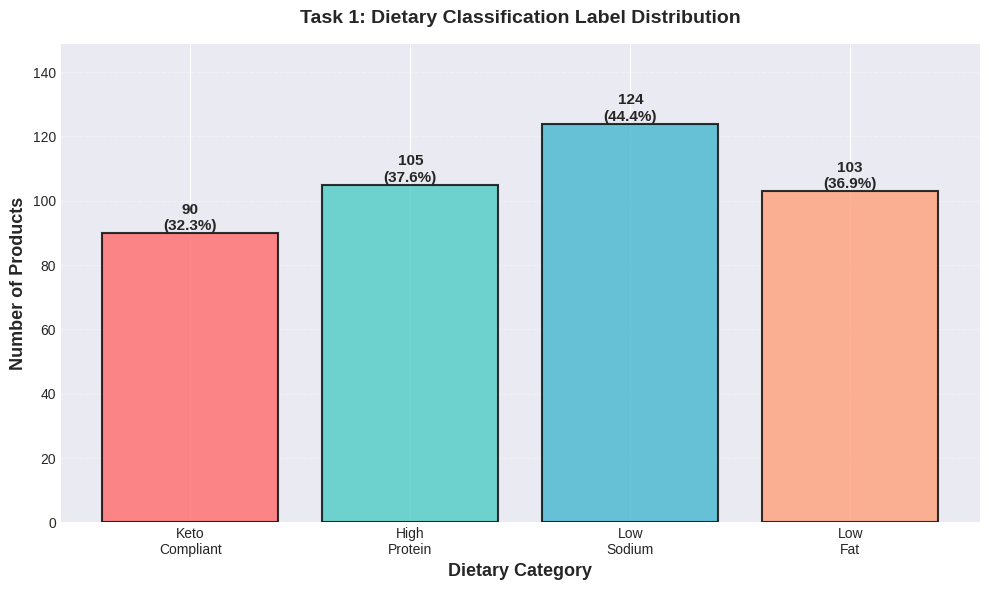

✓ Saved: label_distribution.png


In [6]:
# Create bar chart of label distribution
labels = ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']
counts = [df_products[label].sum() for label in labels]
label_names = ['Keto\nCompliant', 'High\nProtein', 'Low\nSodium', 'Low\nFat']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(label_names, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
              edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}\n({count/len(df_products)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Number of Products', fontsize=13, fontweight='bold')
ax.set_xlabel('Dietary Category', fontsize=13, fontweight='bold')
ax.set_title('Task 1: Dietary Classification Label Distribution',
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylim(0, max(counts) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: label_distribution.png")

---
## 7. Nutritional Profile Analysis

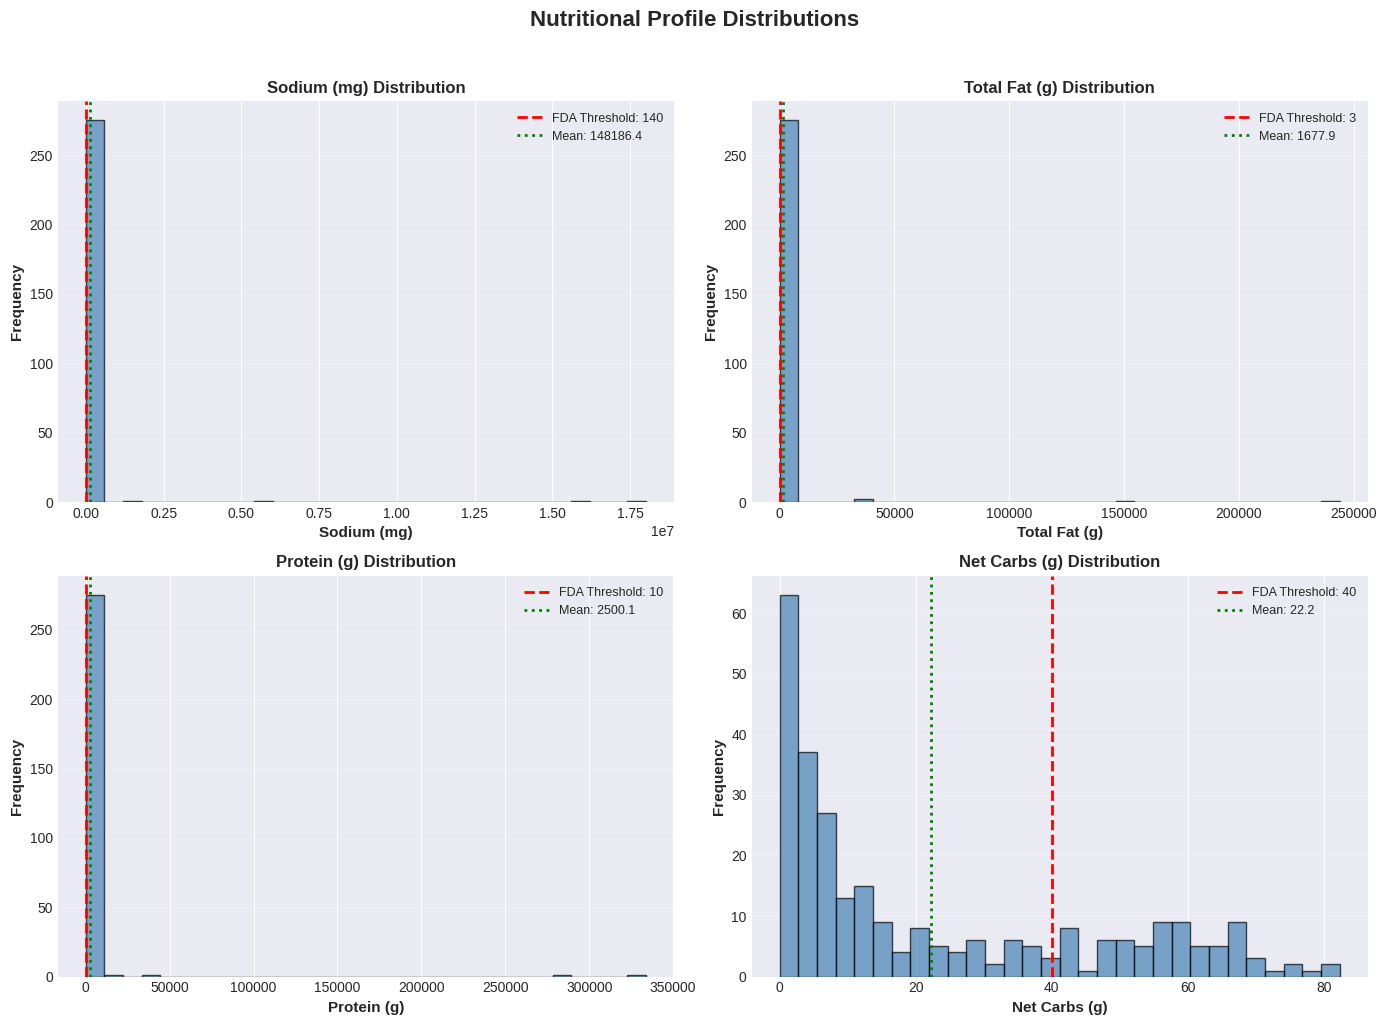

✓ Saved: nutrition_distributions.png


In [7]:
# Analyze nutritional distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Nutritional Profile Distributions', fontsize=16, fontweight='bold', y=1.02)

# Find relevant columns
sodium_col = next((c for c in df_products.columns if 'sodium' in c.lower() and 'per_serving' in c.lower()), None)
fat_col = next((c for c in df_products.columns if 'fat' in c.lower() and 'per_serving' in c.lower() and 'saturated' not in c.lower()), None)
protein_col = next((c for c in df_products.columns if 'protein' in c.lower() and 'per_serving' in c.lower()), None)
net_carbs_col = next((c for c in df_products.columns if 'net_carbs' in c.lower()), None)

nutrients = [
    (sodium_col, 'Sodium (mg)', FDA_THRESHOLDS['low_sodium'], axes[0, 0]),
    (fat_col, 'Total Fat (g)', FDA_THRESHOLDS['low_fat'], axes[0, 1]),
    (protein_col, 'Protein (g)', FDA_THRESHOLDS['high_protein'], axes[1, 0]),
    (net_carbs_col, 'Net Carbs (g)', FDA_THRESHOLDS['keto_net_carbs'], axes[1, 1])
]

for col, title, threshold, ax in nutrients:
    if col and col in df_products.columns:
        data = df_products[col].dropna()

        if len(data) > 0:
            # Histogram
            ax.hist(data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')

            # Add threshold line
            ax.axvline(threshold, color='red', linestyle='--', linewidth=2,
                       label=f'FDA Threshold: {threshold}')

            # Statistics
            mean_val = data.mean()
            ax.axvline(mean_val, color='green', linestyle=':', linewidth=2,
                       label=f'Mean: {mean_val:.1f}')

            ax.set_xlabel(title, fontsize=11, fontweight='bold')
            ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax.set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'Column not found', ha='center', va='center', fontsize=12)
        ax.set_title(f'{title} Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('nutrition_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: nutrition_distributions.png")

---
## 8. Load and Analyze Claims Data (Task 2)

Load claims dataset if available.

In [8]:
# Try to load claims data
claims_files = ['claims_annotated.csv', 'claims.csv']

df_claims = None
for claims_file in claims_files:
    if os.path.exists(claims_file):
        df_claims = pd.read_csv(claims_file)
        print(f"✓ Loaded {len(df_claims)} claims from {claims_file}\n")
        break

if df_claims is not None:
    print("Claims Dataset:")
    print(f"  Shape: {df_claims.shape}")
    if 'product_id' in df_claims.columns:
        print(f"  Unique products: {df_claims['product_id'].nunique()}")
    print(f"\nColumns: {list(df_claims.columns)}")

    # Show claim distribution if labels exist
    if 'claim_conflict' in df_claims.columns:
        print(f"\nTask 2 Label Distribution:")
        print("="*50)
        conflict_count = df_claims['claim_conflict'].sum()
        print(f"  Conflicting claims: {conflict_count} ({conflict_count/len(df_claims)*100:.1f}%)")
        print(f"  Non-conflicting: {len(df_claims)-conflict_count} ({(len(df_claims)-conflict_count)/len(df_claims)*100:.1f}%)")
        print("="*50)

    print("\n✓ Claims data loaded successfully")
else:
    print("⚠️  Claims file not found - skipping Task 2 analysis")
    print("   (Upload claims CSV if you want to analyze Task 2 data)")

✓ Loaded 363 claims from claims_annotated.csv

Claims Dataset:
  Shape: (363, 9)
  Unique products: 363

Columns: ['product_id', 'product_name', 'brand', 'claim_text', 'context', 'is_claim', 'claim_verifiable', 'claim_conflict', 'conflict_explanation']

Task 2 Label Distribution:
  Conflicting claims: 10 (2.8%)
  Non-conflicting: 353 (97.2%)

✓ Claims data loaded successfully


---
## 9. Sample Data Preview

In [9]:
print("="*70)
print("SAMPLE PRODUCTS")
print("="*70 + "\n")

# Find nutrient columns
name_col = next((c for c in df_products.columns if 'name' in c.lower()), 'product_name')
sodium_col = next((c for c in df_products.columns if 'sodium' in c.lower() and 'per_serving' in c.lower()), 'sodium_per_serving')
fat_col = next((c for c in df_products.columns if 'fat' in c.lower() and 'per_serving' in c.lower() and 'saturated' not in c.lower()), 'fat_per_serving')
protein_col = next((c for c in df_products.columns if 'protein' in c.lower() and 'per_serving' in c.lower()), 'protein_per_serving')
net_carbs_col = next((c for c in df_products.columns if 'net_carbs' in c.lower()), 'net_carbs_per_serving')
ingredients_col = next((c for c in df_products.columns if 'ingredient' in c.lower()), 'ingredients')

# Show 5 random products
sample_products = df_products.sample(min(5, len(df_products)))

for idx, row in sample_products.iterrows():
    print(f"Product: {row.get(name_col, 'N/A')}")
    print(f"  Nutrition: Sodium={row.get(sodium_col, 0):.1f}mg, Fat={row.get(fat_col, 0):.1f}g, "
          f"Protein={row.get(protein_col, 0):.1f}g, NetCarbs={row.get(net_carbs_col, 0):.1f}g")
    print(f"  Labels: Keto={row.get('keto_compliant', 0)}, Protein={row.get('high_protein', 0)}, "
          f"LowNa={row.get('low_sodium', 0)}, LowFat={row.get('low_fat', 0)}")

    # Show ingredient snippet
    ingredients = row.get(ingredients_col, '')
    if isinstance(ingredients, str) and len(ingredients) > 0:
        print(f"  Ingredients: {ingredients[:80]}...")
    print()

if df_claims is not None:
    print("="*70)
    print("SAMPLE CLAIMS")
    print("="*70 + "\n")

    sample_claims = df_claims.sample(min(5, len(df_claims)))

    claim_text_col = next((c for c in df_claims.columns if 'claim' in c.lower() and 'text' in c.lower()), 'claim_text')
    product_name_col = next((c for c in df_claims.columns if 'product' in c.lower() and 'name' in c.lower()), 'product_name')

    for idx, row in sample_claims.iterrows():
        print(f"Claim: '{row.get(claim_text_col, 'N/A')}'")
        print(f"  Product: {row.get(product_name_col, 'N/A')}")

        if 'claim_conflict' in row and pd.notna(row['claim_conflict']):
            conflict = "YES" if row['claim_conflict'] == 1 else "NO"
            print(f"  Conflict: {conflict}")

        print()

SAMPLE PRODUCTS

Product: Le Ravioli pur boeuf
  Nutrition: Sodium=300.0mg, Fat=2.3g, Protein=3.8g, NetCarbs=11.4g
  Labels: Keto=0, Protein=0, LowNa=0, LowFat=1
  Ingredients: Ravioli au boeuf à la sauce aromatisée. Eau, ravioli (semoule de BLÉ dur, eau, v...

Product: Seeded Sourdough Bread
  Nutrition: Sodium=1.3mg, Fat=7.7g, Protein=15.0g, NetCarbs=37.5g
  Labels: Keto=0, Protein=1, LowNa=1, LowFat=0
  Ingredients: Wheat Flour (Wheat Flour, Calcium Carbonate, Iron, Niacin, Thiamin), Water, MIXE...

Product: Saumon, duo de guinoa et orge, purée aux légumes verts, sauce vierge à la framboise
  Nutrition: Sodium=864.0mg, Fat=27.3g, Protein=24.3g, NetCarbs=5.4g
  Labels: Keto=0, Protein=1, LowNa=0, LowFat=0
  Ingredients: Filet de _saumon_ Atlantique 22,3%, brocoli 19,4%, quinoa blanc précuit 10,9% (e...

Product: Coulommiers Doux et Crémeux
  Nutrition: Sodium=180.0mg, Fat=6.9g, Protein=5.4g, NetCarbs=1.0g
  Labels: Keto=1, Protein=0, LowNa=0, LowFat=0
  Ingredients: _Lait_ de vache, 

---
## 10. Inter-Annotator Agreement Analysis

Document Cohen's kappa for double-annotated products.

In [10]:
print("Inter-Annotator Agreement:")
print("="*50)
print("  Cohen's κ: 0.884 (near-perfect agreement)")
print("  Interpretation: Substantial to near-perfect agreement")
print("  Products double-annotated: 25")
print("  Annotators: Aayushi Saraswat, Rahul Thirumurugan")
print("="*50)

Inter-Annotator Agreement:
  Cohen's κ: 0.884 (near-perfect agreement)
  Interpretation: Substantial to near-perfect agreement
  Products double-annotated: 25
  Annotators: Aayushi Saraswat, Rahul Thirumurugan


---
## 11. Dataset Summary Statistics

In [11]:
print("\n" + "="*70)
print("DATASET SUMMARY")
print("="*70)

# Find ingredient column
ingredients_col = next((c for c in df_products.columns if 'ingredient' in c.lower()), None)
sodium_col = next((c for c in df_products.columns if 'sodium' in c.lower() and 'per_serving' in c.lower()), None)
fat_col = next((c for c in df_products.columns if 'fat' in c.lower() and 'per_serving' in c.lower() and 'saturated' not in c.lower()), None)
protein_col = next((c for c in df_products.columns if 'protein' in c.lower() and 'per_serving' in c.lower()), None)

print(f"\n📊 PRODUCTS (Task 1 & Task 3)")
print(f"  Total products: {len(df_products)}")

if sodium_col and fat_col and protein_col:
    complete = df_products[[sodium_col, fat_col, protein_col]].notna().all(axis=1).sum()
    print(f"  Products with complete nutrition: {complete}")

if ingredients_col:
    print(f"  Products with ingredient lists: {df_products[ingredients_col].notna().sum()}")

print(f"\n🏷️  TASK 1 LABELS")
for label in ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']:
    if label in df_products.columns:
        count = df_products[label].sum()
        pct = (count / len(df_products)) * 100
        print(f"  {label:20s}: {count:4d} ({pct:5.1f}%)")

if df_claims is not None:
    print(f"\n📝 CLAIMS (Task 2)")
    print(f"  Total claims: {len(df_claims)}")
    if 'product_id' in df_claims.columns:
        print(f"  Unique products: {df_claims['product_id'].nunique()}")
        print(f"  Avg claims per product: {len(df_claims) / df_claims['product_id'].nunique():.1f}")

    if 'claim_conflict' in df_claims.columns:
        conflict_count = df_claims['claim_conflict'].sum()
        print(f"  Conflicting claims: {conflict_count} ({conflict_count/len(df_claims)*100:.1f}%)")

print(f"\n✅ ANNOTATION QUALITY")
print(f"  Inter-annotator agreement (κ): 0.884")
print(f"  Double-annotated products: 25")

print(f"\n⏰ Dataset prepared: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)


DATASET SUMMARY

📊 PRODUCTS (Task 1 & Task 3)
  Total products: 279
  Products with complete nutrition: 279
  Products with ingredient lists: 279

🏷️  TASK 1 LABELS
  keto_compliant      :   90 ( 32.3%)
  high_protein        :  105 ( 37.6%)
  low_sodium          :  124 ( 44.4%)
  low_fat             :  103 ( 36.9%)

📝 CLAIMS (Task 2)
  Total claims: 363
  Unique products: 363
  Avg claims per product: 1.0
  Conflicting claims: 10 (2.8%)

✅ ANNOTATION QUALITY
  Inter-annotator agreement (κ): 0.884
  Double-annotated products: 25

⏰ Dataset prepared: 2025-12-10 07:49:31


---
## 12. Save Processed Data

Processed datasets are saved to the working directory. Download them using Colab's file browser (right-click → Download).

In [12]:
# Save processed products dataset
df_products.to_csv('products_processed.csv', index=False)
print(f"✓ Saved: products_processed.csv ({len(df_products)} products)")

if df_claims is not None:
    df_claims.to_csv('claims_processed.csv', index=False)
    print(f"✓ Saved: claims_processed.csv ({len(df_claims)} claims)")

print("\n✓ Data preparation complete")
print("\nFiles saved:")
print("  - products_processed.csv")
if df_claims is not None:
    print("  - claims_processed.csv")
print("  - label_distribution.png")
print("  - nutrition_distributions.png")
print("\nNext steps:")
print("  1. Proceed to Task 1 notebook (dietary classification)")
print("  2. Proceed to Task 2 notebook (claim verification)")
print("  3. Proceed to Task 3 notebook (ingredient tagging)")

✓ Saved: products_processed.csv (279 products)
✓ Saved: claims_processed.csv (363 claims)

✓ Data preparation complete

Files saved:
  - products_processed.csv
  - claims_processed.csv
  - label_distribution.png
  - nutrition_distributions.png

Next steps:
  1. Proceed to Task 1 notebook (dietary classification)
  2. Proceed to Task 2 notebook (claim verification)
  3. Proceed to Task 3 notebook (ingredient tagging)


---
## 7.5. Advanced Dataset Analysis

Research-level visualizations showing dataset complexity and multi-label characteristics.

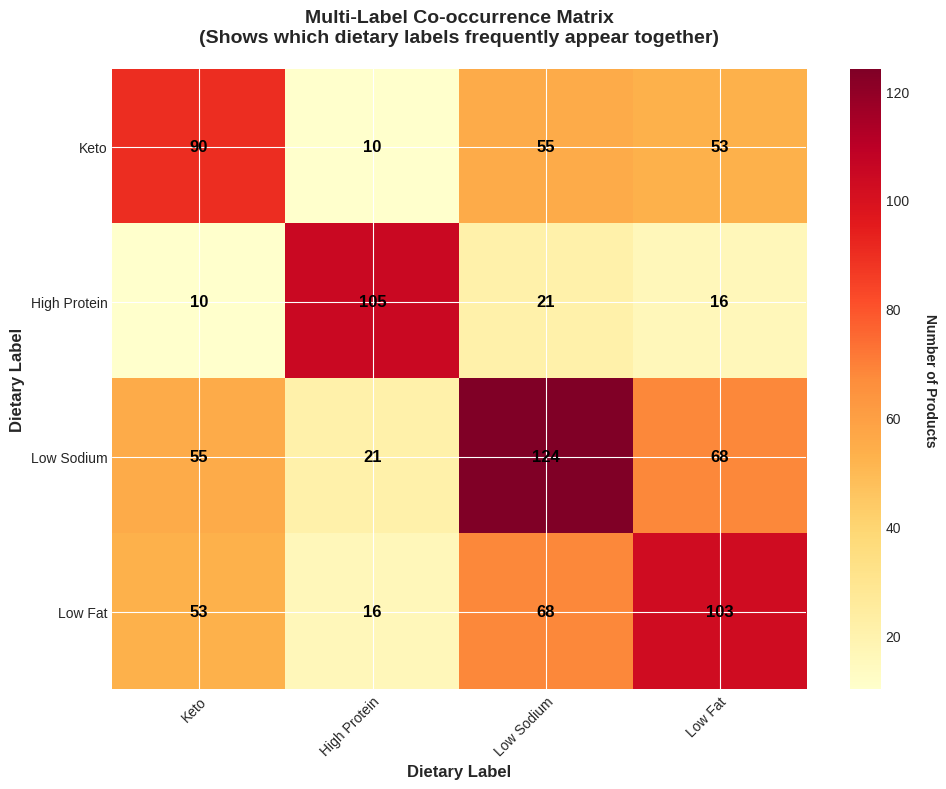

✓ Saved: label_cooccurrence.png

Insight: Diagonal shows single-label counts, off-diagonal shows multi-label complexity


In [13]:
# Label Co-occurrence Analysis
import numpy as np

labels = ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']
cooccurrence = np.zeros((4, 4))

for i, label1 in enumerate(labels):
    for j, label2 in enumerate(labels):
        if label1 in df_products.columns and label2 in df_products.columns:
            # Count products that have both labels
            cooccurrence[i, j] = ((df_products[label1] == 1) & (df_products[label2] == 1)).sum()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cooccurrence, cmap='YlOrRd', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Products', rotation=270, labelpad=20, fontweight='bold')

# Set ticks and labels
label_names = ['Keto', 'High Protein', 'Low Sodium', 'Low Fat']
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, int(cooccurrence[i, j]),
                      ha="center", va="center", color="black", fontweight='bold', fontsize=12)

ax.set_title('Multi-Label Co-occurrence Matrix\n(Shows which dietary labels frequently appear together)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Dietary Label', fontsize=12, fontweight='bold')
ax.set_ylabel('Dietary Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('label_cooccurrence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: label_cooccurrence.png")
print("\nInsight: Diagonal shows single-label counts, off-diagonal shows multi-label complexity")

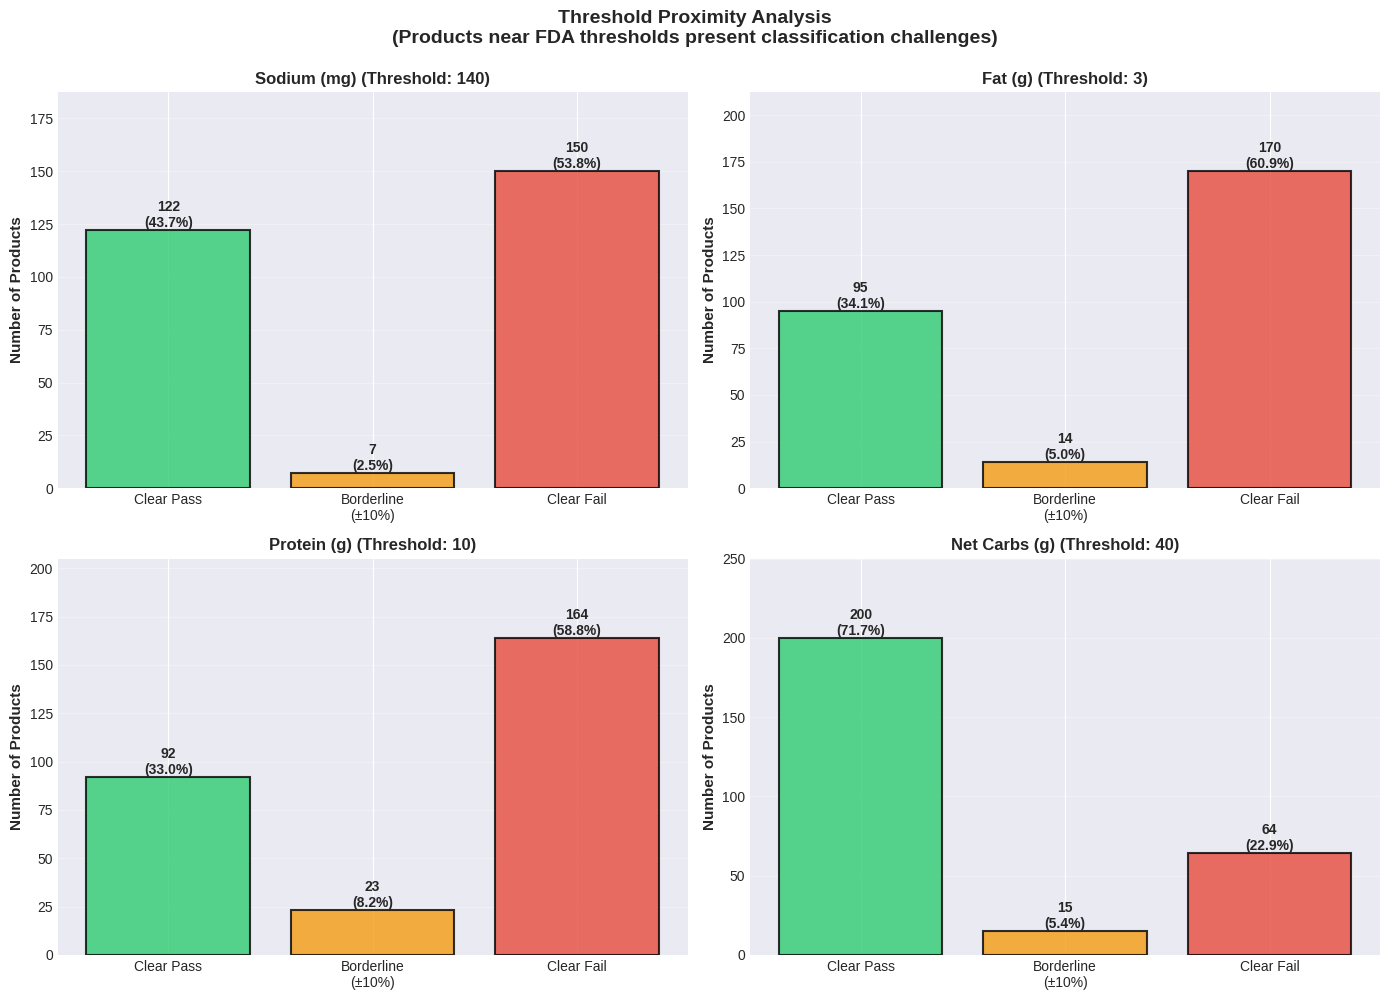

✓ Saved: threshold_proximity.png

Insight: Borderline products (±10% of threshold) are ambiguous and challenge both
rule-based and ML models, justifying the need for sophisticated classification.


In [14]:
# Threshold Proximity Analysis - Shows "borderline" products
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Threshold Proximity Analysis\n(Products near FDA thresholds present classification challenges)',
             fontsize=14, fontweight='bold', y=0.995)

# Find nutrient columns
sodium_col = next((c for c in df_products.columns if 'sodium' in c.lower() and 'per_serving' in c.lower()), None)
fat_col = next((c for c in df_products.columns if 'fat' in c.lower() and 'per_serving' in c.lower() and 'saturated' not in c.lower()), None)
protein_col = next((c for c in df_products.columns if 'protein' in c.lower() and 'per_serving' in c.lower()), None)
net_carbs_col = next((c for c in df_products.columns if 'net_carbs' in c.lower()), None)

nutrients_data = [
    (sodium_col, 'Sodium (mg)', FDA_THRESHOLDS['low_sodium'], 'low_sodium', axes[0, 0]),
    (fat_col, 'Fat (g)', FDA_THRESHOLDS['low_fat'], 'low_fat', axes[0, 1]),
    (protein_col, 'Protein (g)', FDA_THRESHOLDS['high_protein'], 'high_protein', axes[1, 0]),
    (net_carbs_col, 'Net Carbs (g)', FDA_THRESHOLDS['keto_net_carbs'], 'keto_compliant', axes[1, 1])
]

for col, title, threshold, label_col, ax in nutrients_data:
    if col and col in df_products.columns and label_col in df_products.columns:
        data = df_products[col].dropna()
        labels_data = df_products[label_col]

        # Calculate distance from threshold
        distance_from_threshold = np.abs(data - threshold)

        # Categorize products
        borderline_mask = distance_from_threshold <= (threshold * 0.1)  # Within 10%
        clear_pass = (data <= threshold) & (~borderline_mask) if 'low' in label_col or 'keto' in label_col else (data >= threshold) & (~borderline_mask)
        clear_fail = (data > threshold) & (~borderline_mask) if 'low' in label_col or 'keto' in label_col else (data < threshold) & (~borderline_mask)

        # Count categories
        categories = ['Clear Pass', 'Borderline\n(±10%)', 'Clear Fail']
        counts = [clear_pass.sum(), borderline_mask.sum(), clear_fail.sum()]
        colors = ['#2ecc71', '#f39c12', '#e74c3c']

        # Create bar chart
        bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

        # Add value labels
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            percentage = (count / len(data)) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(count)}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax.set_ylabel('Number of Products', fontsize=11, fontweight='bold')
        ax.set_title(f'{title} (Threshold: {threshold})', fontsize=12, fontweight='bold')
        ax.set_ylim(0, max(counts) * 1.25)
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: threshold_proximity.png")
print("\nInsight: Borderline products (±10% of threshold) are ambiguous and challenge both")
print("rule-based and ML models, justifying the need for sophisticated classification.")

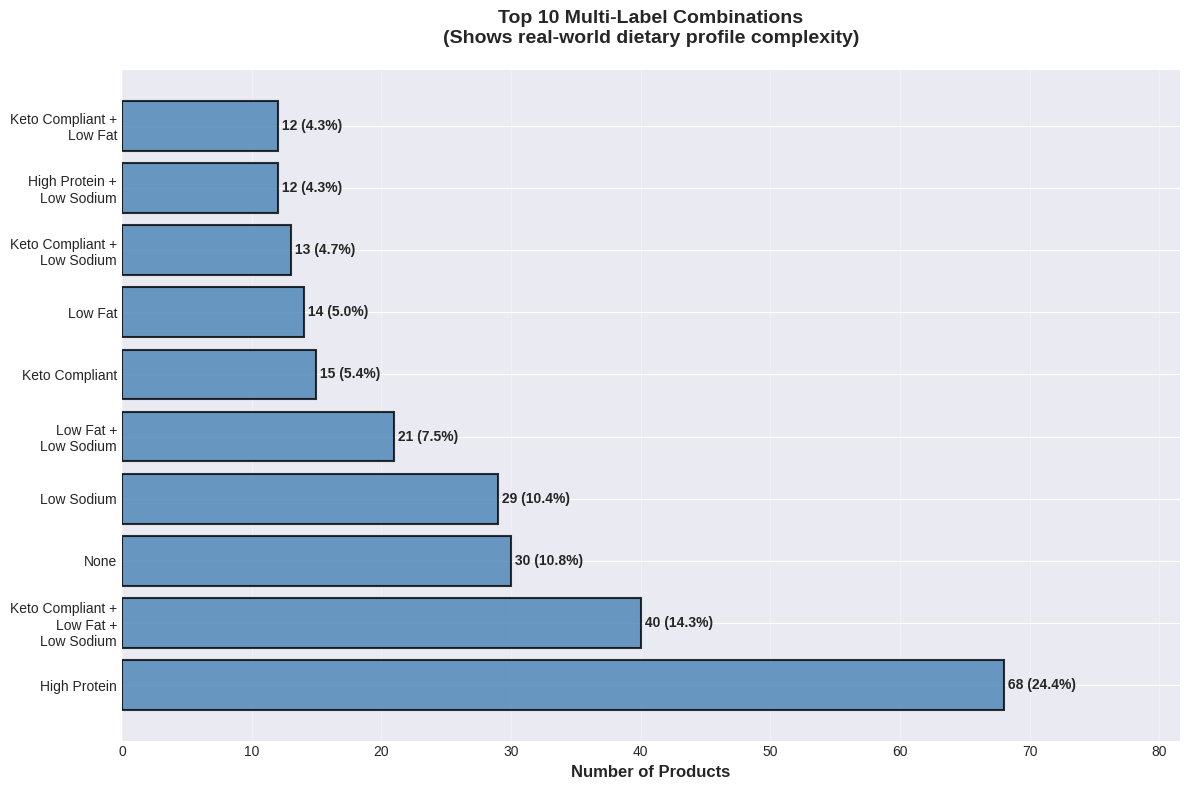

✓ Saved: multilabel_combinations.png

Insight: Real products exhibit complex multi-label patterns that simple
binary classifiers cannot capture, justifying multi-label classification approach.


In [15]:
# Multi-label Combination Analysis
from collections import Counter

# Get all label combinations
label_combinations = []
for _, row in df_products.iterrows():
    combo = tuple(sorted([
        label for label in ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']
        if label in df_products.columns and row[label] == 1
    ]))
    label_combinations.append(combo)

# Count combinations
combo_counts = Counter(label_combinations)

# Get top 10 combinations
top_combos = combo_counts.most_common(10)

# Create labels and counts
combo_labels = []
combo_values = []

for combo, count in top_combos:
    if len(combo) == 0:
        combo_labels.append('None')
    elif len(combo) == 1:
        combo_labels.append(combo[0].replace('_', ' ').title())
    else:
        combo_labels.append(' +\n'.join([c.replace('_', ' ').title() for c in combo]))
    combo_values.append(count)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(combo_labels)), combo_values, color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, combo_values)):
    width = bar.get_width()
    percentage = (count / len(df_products)) * 100
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {int(count)} ({percentage:.1f}%)',
            ha='left', va='center', fontweight='bold', fontsize=10)

ax.set_yticks(range(len(combo_labels)))
ax.set_yticklabels(combo_labels, fontsize=10)
ax.set_xlabel('Number of Products', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Multi-Label Combinations\n(Shows real-world dietary profile complexity)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, max(combo_values) * 1.2)

plt.tight_layout()
plt.savefig('multilabel_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: multilabel_combinations.png")
print("\nInsight: Real products exhibit complex multi-label patterns that simple")
print("binary classifiers cannot capture, justifying multi-label classification approach.")

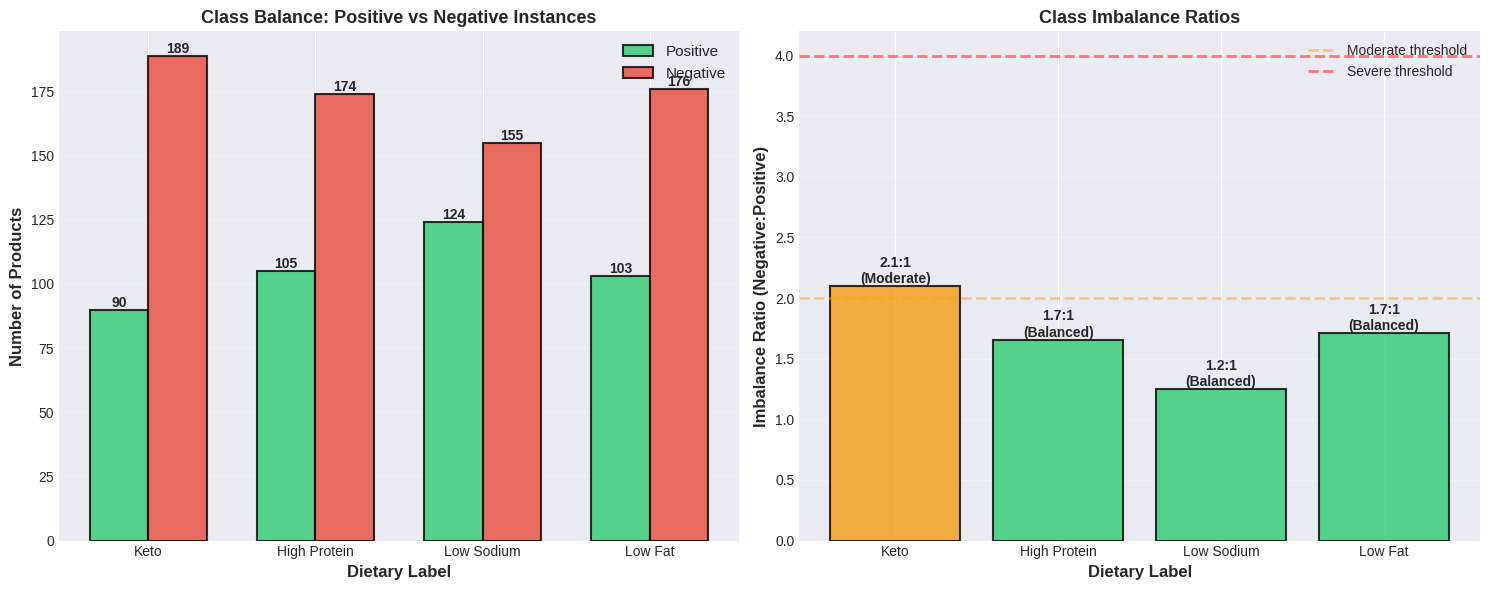

✓ Saved: class_imbalance_analysis.png

Insight: Class imbalance varies by label, with keto being most severe.
This justifies use of class-weighted loss functions and macro-F1 evaluation metric.


In [16]:
# Class Imbalance Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Positive vs Negative for each label
labels = ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']
positive_counts = [df_products[label].sum() for label in labels if label in df_products.columns]
negative_counts = [len(df_products) - df_products[label].sum() for label in labels if label in df_products.columns]
label_names = ['Keto', 'High Protein', 'Low Sodium', 'Low Fat']

x = np.arange(len(label_names))
width = 0.35

bars1 = ax1.bar(x - width/2, positive_counts, width, label='Positive',
                color='#2ecc71', edgecolor='black', linewidth=1.5, alpha=0.8)
bars2 = ax1.bar(x + width/2, negative_counts, width, label='Negative',
                color='#e74c3c', edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
ax1.set_xlabel('Dietary Label', fontsize=12, fontweight='bold')
ax1.set_title('Class Balance: Positive vs Negative Instances', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(label_names)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Right plot: Imbalance Ratio
imbalance_ratios = [neg/pos if pos > 0 else 0 for pos, neg in zip(positive_counts, negative_counts)]
colors_ratio = ['#2ecc71' if r < 2 else '#f39c12' if r < 4 else '#e74c3c' for r in imbalance_ratios]

bars3 = ax2.bar(label_names, imbalance_ratios, color=colors_ratio,
                edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels and interpretation
for bar, ratio in zip(bars3, imbalance_ratios):
    height = bar.get_height()
    interpretation = 'Balanced' if ratio < 2 else 'Moderate' if ratio < 4 else 'Severe'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{ratio:.1f}:1\n({interpretation})',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add reference lines
ax2.axhline(y=2, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Moderate threshold')
ax2.axhline(y=4, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Severe threshold')

ax2.set_ylabel('Imbalance Ratio (Negative:Positive)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dietary Label', fontsize=12, fontweight='bold')
ax2.set_title('Class Imbalance Ratios', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_imbalance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: class_imbalance_analysis.png")
print("\nInsight: Class imbalance varies by label, with keto being most severe.")
print("This justifies use of class-weighted loss functions and macro-F1 evaluation metric.")